# 6.6 Sourcing & Analyzing Time-Series Data 
# Import Price Index: EU - All Commodities

### This script contains the following:
#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

## 1. Importing your libraries and data

In [1]:
# import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'UfQxwKSvs2VzA-m_Nk2J'

In [4]:
# Importing the Federal Reserve Economic Data "Import Price Index: European Union - All commodities" variable.

data = quandl.get('FRED/EECTOT')

In [5]:
data.head(5)

,Value
Date,
1990-12-01,93.8
1991-03-01,95.2
1991-06-01,91.6
1991-09-01,91.7
1991-12-01,94.0


In [6]:
data.shape

(360, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

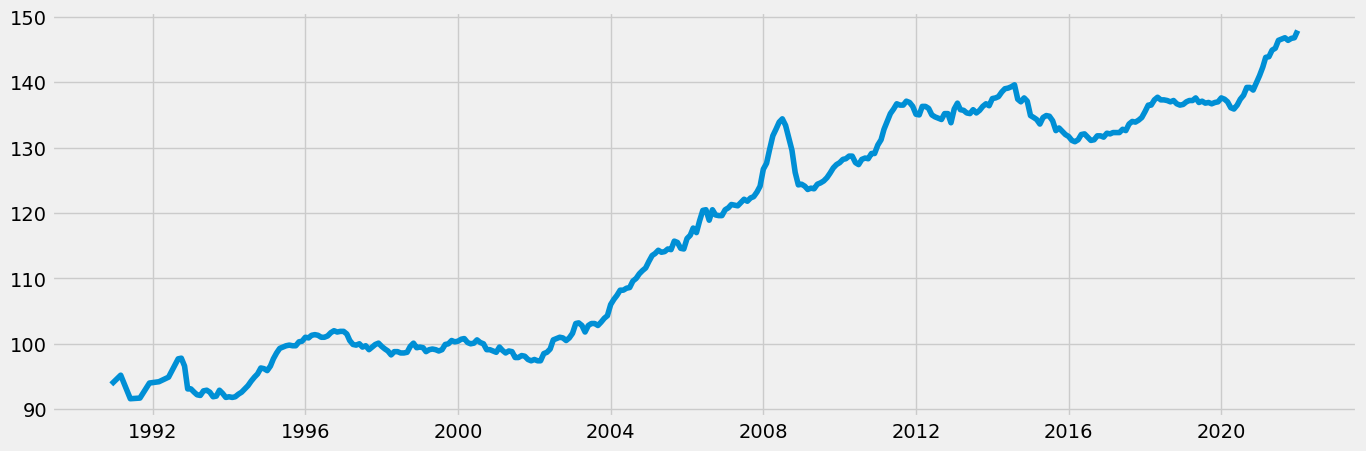

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1990-12-01,93.8
1,1991-03-01,95.2
2,1991-06-01,91.6
3,1991-09-01,91.7
4,1991-12-01,94.0


In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '2002-01-01') & (data_2['Date'] < '2022-12-01')]

In [13]:
data_sub.shape

(241, 2)

In [14]:
data_sub.head()

,Date,Value
119,2002-01-01,97.6
120,2002-02-01,97.4
121,2002-03-01,97.4
122,2002-04-01,98.5
123,2002-05-01,98.7


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2002-01-01,97.6
2002-02-01,97.4
2002-03-01,97.4
2002-04-01,98.5
2002-05-01,98.7


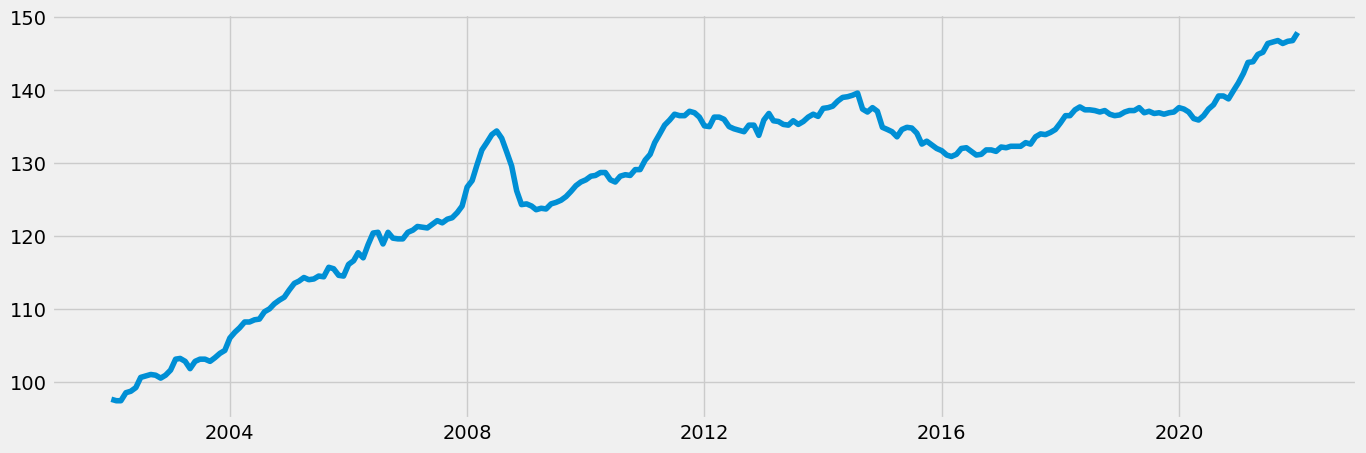

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 3. Time-series analysis: decomposition

In [24]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [25]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

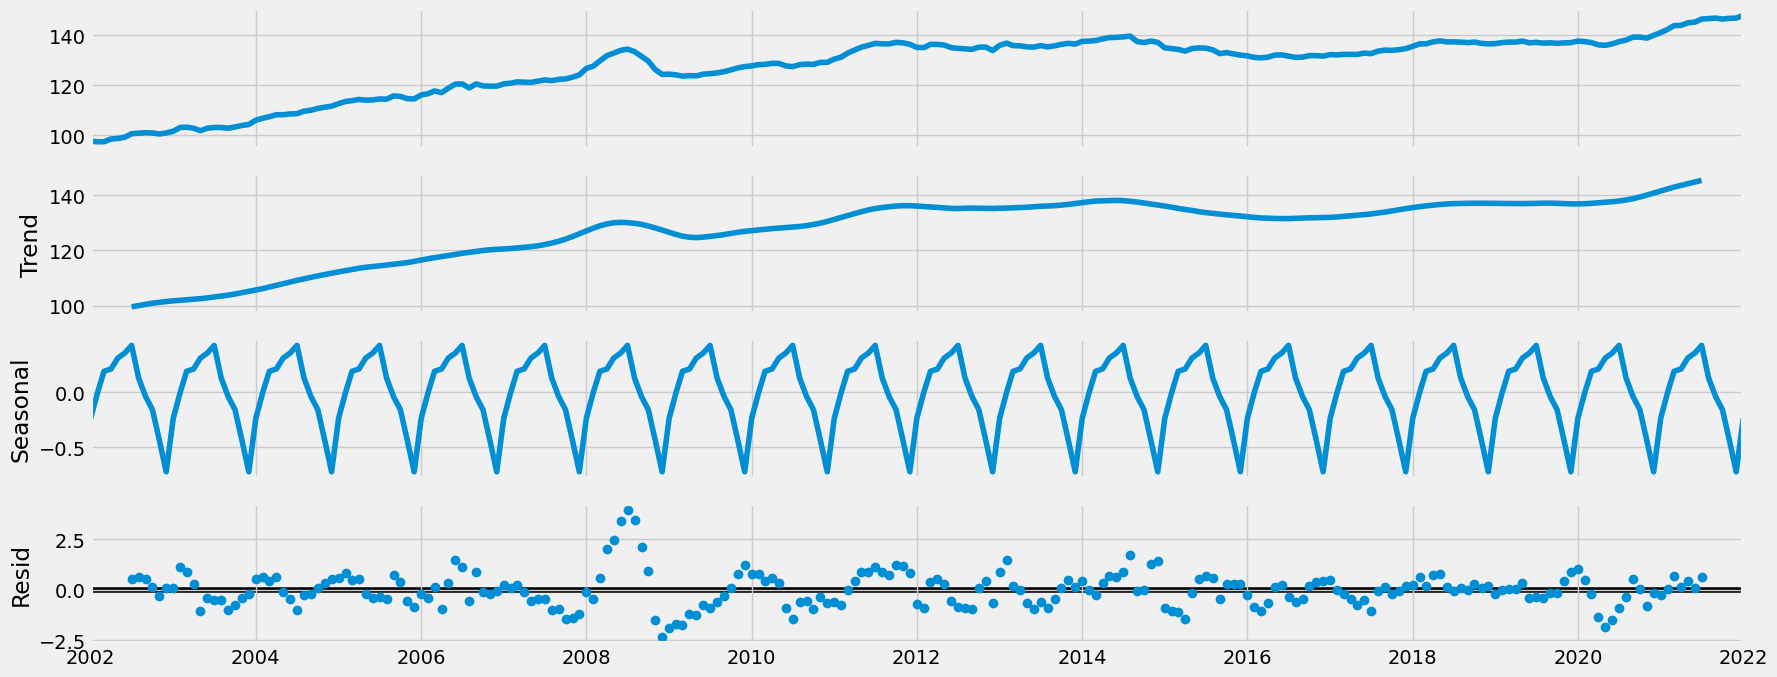

In [26]:
# Plot the separate components

decomposition.plot()
plt.show()

The trend in the chart above gradually rises in a linear fashion from 2002 until 2022. There is seasonality present in this data, represented by the spiked curve that changes at regular intervals. The residual chart shows the noise of the data, it shows the strong fluctuation during the year 2009 due to the financial crisis. I will smooth the data since the deviation vary between -2.5 to +2.5.

In [39]:
# Perform the weighted moving average on the 'Value' column

data_sub['Smoothed_Value'] = data_sub['Value'].rolling(window=len(weights), center=False).apply(lambda x: np.sum(x * weights), raw=True)

In [33]:
# Define the weights for the moving average

weights = np.array([0.1, 0.2, 0.3, 0.4])

In [40]:
# Ensure that the length of the result matches the original data length minus the weights length

data_smooth = data_sub[len(weights) - 1:]

In [44]:
data_smooth

,Value,Smoothed_Value
datetime,,
2002-04-01,98.5,97.86
2002-05-01,98.7,98.25
2002-06-01,99.2,98.73
2002-07-01,100.6,99.59
2002-08-01,100.8,100.21
...,...,...
2021-09-01,146.8,146.50
2021-10-01,146.4,146.56
2021-11-01,146.7,146.62


In [48]:
# drop the 'Value' column

data_smooth = data_smooth.drop(columns =['Value'])

In [49]:
data_smooth.head()

,Smoothed_Value
datetime,
2002-04-01,97.86
2002-05-01,98.25
2002-06-01,98.73
2002-07-01,99.59
2002-08-01,100.21


In [50]:
# Decompose the time series using an additive model

decomposition_smooth = sm.tsa.seasonal_decompose(data_smooth, model='additive')

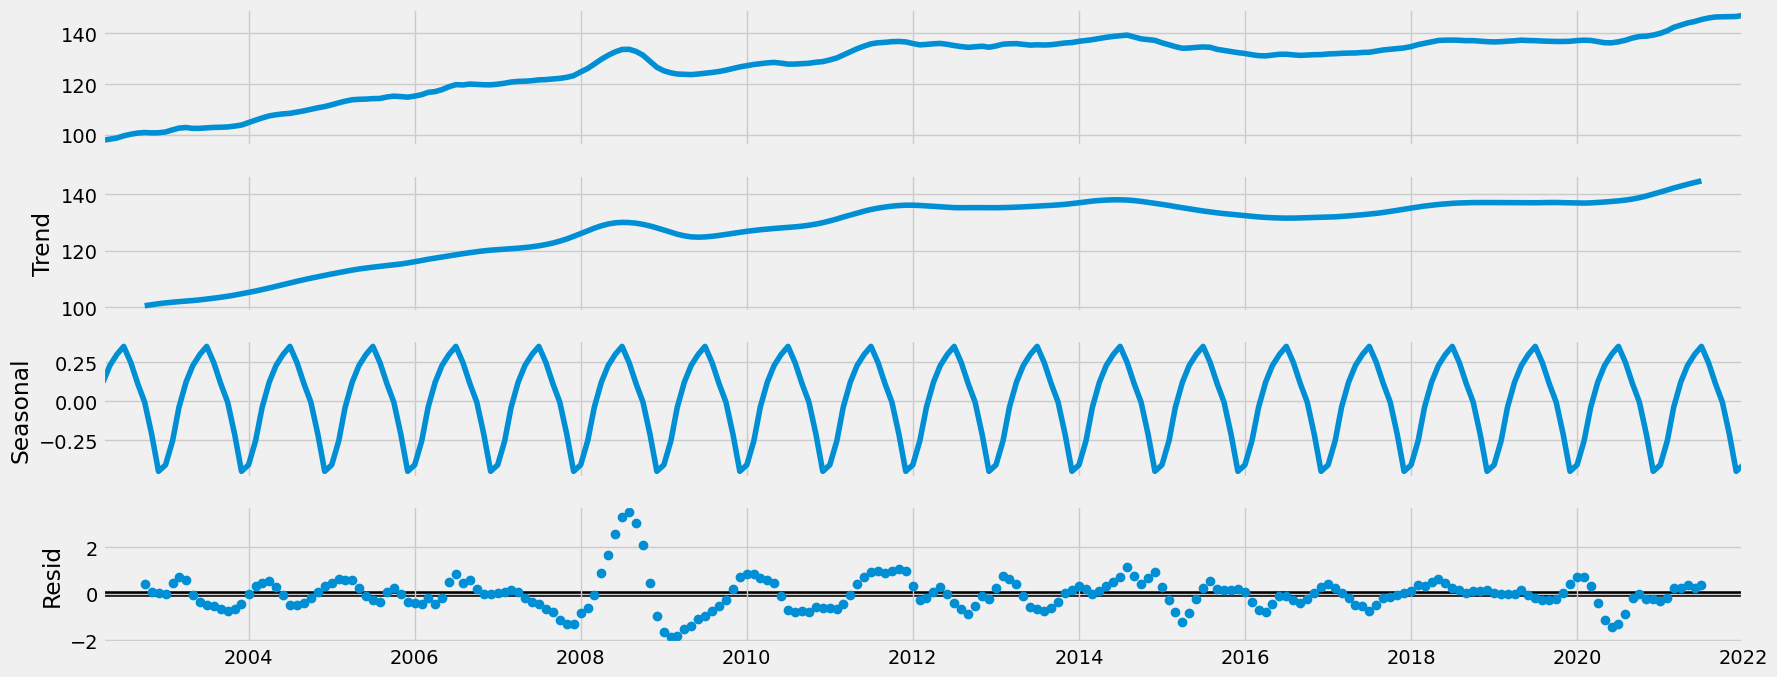

In [51]:
# Plot the separate components

decomposition_smooth.plot()
plt.show()

After smoothing the data, the residual chart seems to have less noise.

### 4. Testing for stationarity

In [53]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_smooth['Smoothed_Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.167302
p-value                          0.218326
Number of Lags Used              7.000000
Number of Observations Used    230.000000
Critical Value (1%)             -3.459106
Critical Value (5%)             -2.874190
Critical Value (10%)            -2.573512
dtype: float64


The test statistic is larger than the critical value, so we must stationarize the data.

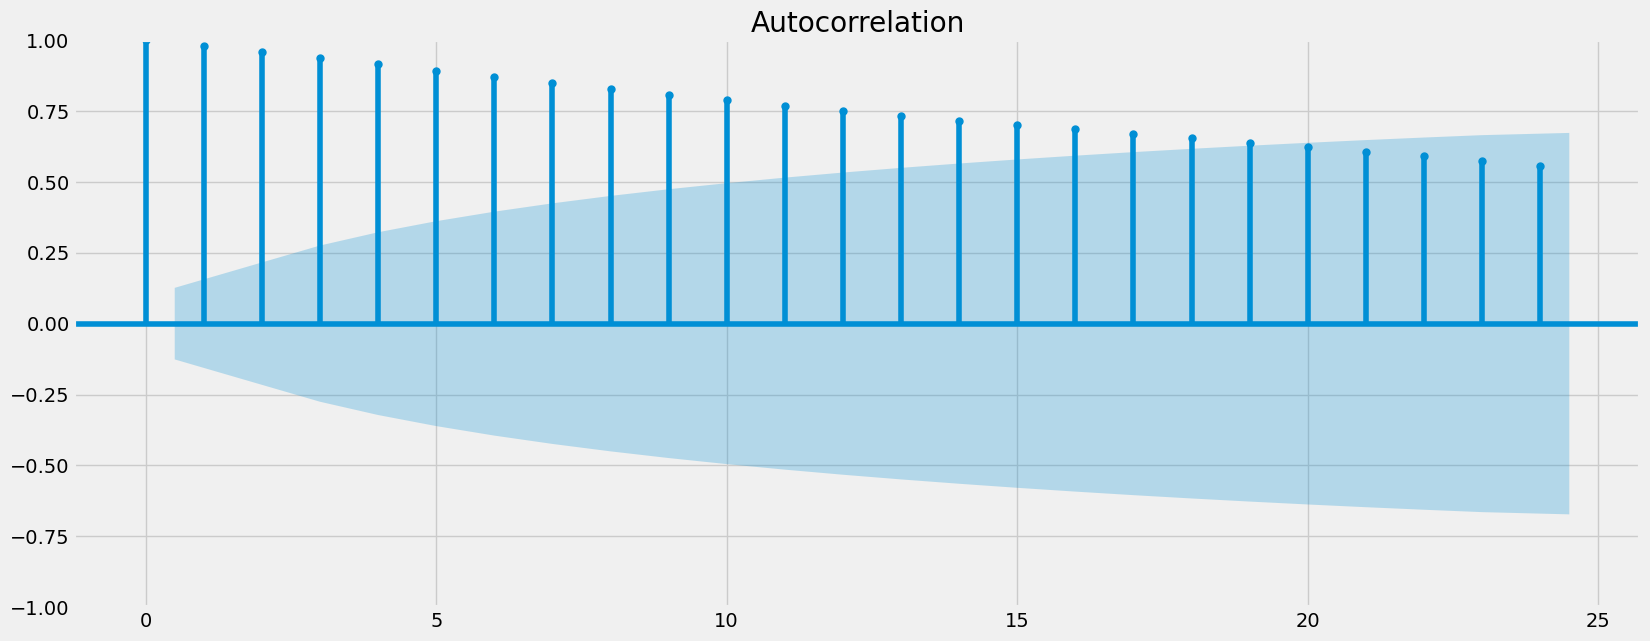

In [28]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

From the result of the Dickey-Fuller test, there are many lags beyond this interval, so it confirms that the data is non-stationary.

### 5. Stationarizing the Federal Reserve Economic Data

In [55]:
data_diff = data_smooth - data_smooth.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [56]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [57]:
data_diff.head()

,Smoothed_Value
datetime,
2002-05-01,0.39
2002-06-01,0.48
2002-07-01,0.86
2002-08-01,0.62
2002-09-01,0.47


In [58]:
data_diff.columns

Index(['Smoothed_Value'], dtype='object')

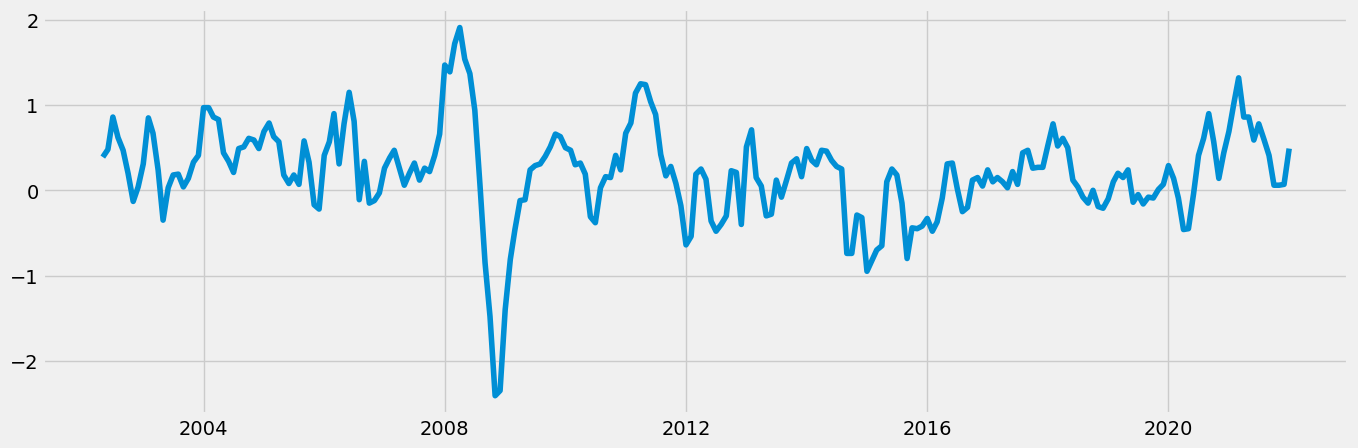

In [59]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [60]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.117056
p-value                          0.000013
Number of Lags Used              7.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


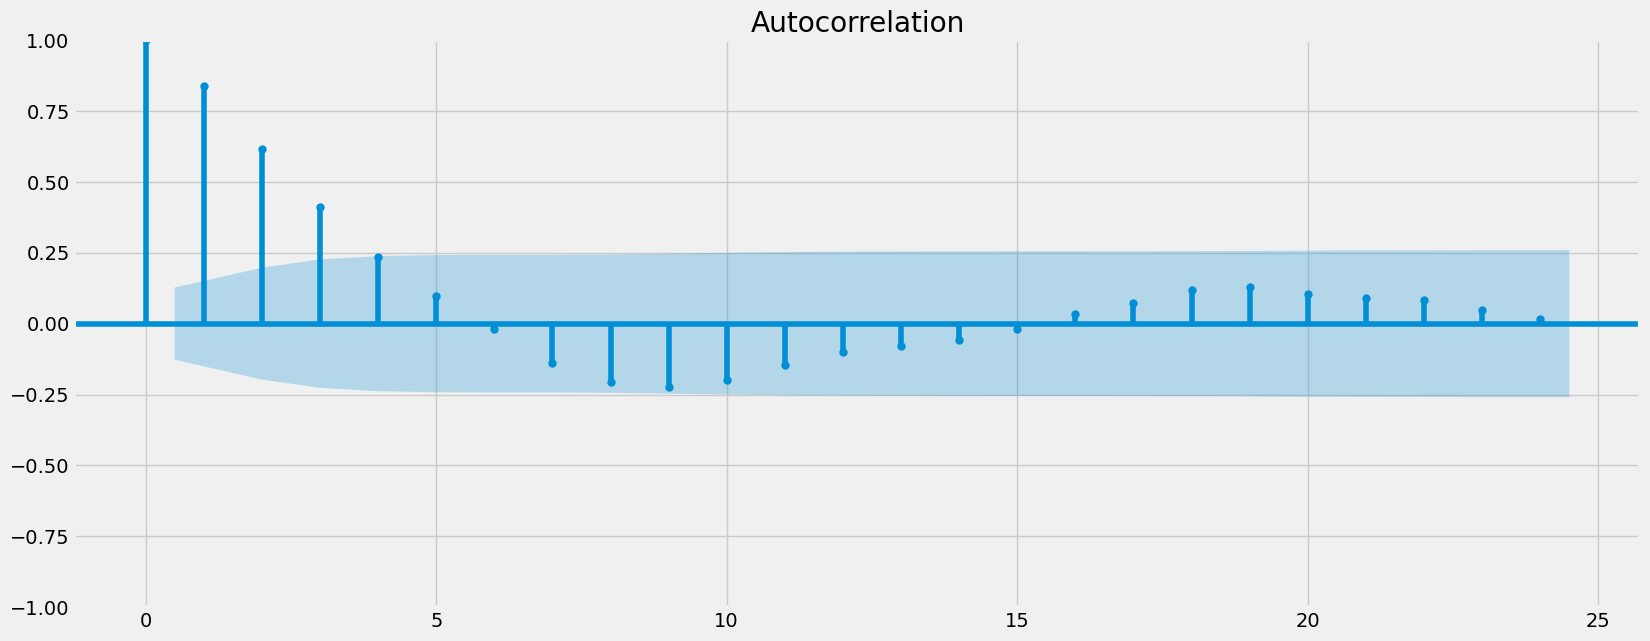

In [61]:
plot_acf(data_diff)
plt.show()

Test statistic is now smaller than all the Critical Values.